# Brownian Class

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

class Brownian():
    def __init__(self, M=50):
        assert type(M) == int

        self.M = M
        self.board = np.zeros((M, M))

        # Generate the walls and represent them as 1
        self.board[0, :] = 1
        self.board[-1, :] = 1
        self.board[:, 0] = 1
        self.board[:, -1] = 1

        self.holes = []

        # Generate two non-overlapping square holes closer to the center
        center_x = M // 2
        center_y = M // 2
        max_offset = min(center_x, center_y) - 1  # Adjust the offset as needed

        for _ in range(2):
            while True:
                hole_size = np.random.randint(1, M // 4)
                hole_x = np.random.randint(center_x - max_offset, center_x + max_offset - hole_size)
                hole_y = np.random.randint(center_y - max_offset, center_y + max_offset - hole_size)

                # Check if the hole overlaps with existing holes
                overlaps = self._check_overlap(hole_x, hole_y, hole_size)

                if not overlaps:
                    break

            self.board[hole_x:hole_x + hole_size, hole_y:hole_y + hole_size] = 1
            self.holes.append((hole_x, hole_y, hole_size, hole_size))

        #lines that count how many times goes around holes
        self.lines = []  # List to store the lines perpendicular to the sides of the holes

        for hole in self.holes:
            hole_x, hole_y, hole_width, hole_height = hole

            # Top line
            top_line = ((hole_x, hole_y), (hole_x + hole_width, hole_y))
            self.lines.append(top_line)

            # Right line
            right_line = ((hole_x + hole_width, hole_y), (self.M - 1, hole_y))
            self.lines.append(right_line)

            # Bottom line
            bottom_line = ((hole_x + hole_width, hole_y + hole_height), (self.M - 1, hole_y + hole_height))
            self.lines.append(bottom_line)

            # Left line
            left_line = ((hole_x, hole_y + hole_height), (hole_x, self.M - 1))
            self.lines.append(left_line)


    def _check_overlap(self, hole_x, hole_y, hole_size):
        occupied = self.board[hole_x:hole_x + hole_size, hole_y:hole_y + hole_size]
        return np.any(occupied)



    def gen_random_walk(self, n_steps=100000, bias=None):
        x = np.zeros(n_steps)
        y = np.zeros(n_steps)

        start_x, start_y = self._get_valid_start_point()
        x[0] = start_x
        y[0] = start_y

        for i in range(1, n_steps - 1):
            if bias is not None:
                choice = self._get_direction_with_bias(bias)
            else:
                choice = np.random.randint(4)

            dx, dy = self._get_direction(choice)

            new_x = x[i - 1] + dx
            new_y = y[i - 1] + dy

            if self._is_hole(new_x, new_y) or self._is_wall(new_x, new_y):
                new_x = x[i - 1]
                new_y = y[i - 1]

            x[i] = new_x
            y[i] = new_y

        return x, y

    def _get_direction(self, choice):
        if choice == 0:
            return 0, 1  # Up
        elif choice == 1:
            return 0, -1  # Down
        elif choice == 2:
            return 1, 0  # Right
        else:
            return -1, 0  # Left
        
    def _get_direction_with_bias(self, bias):
        choices = [0, 1, 2, 3]
        probabilities = [bias['up'], bias['down'], bias['right'], bias['left']]
        choice = np.random.choice(choices, p=probabilities)
        return int(choice)


    def _get_valid_start_point(self):
        while True:
            start_x = np.random.randint(1, self.M - 1)
            start_y = np.random.randint(1, self.M - 1)
            if not self._is_hole(start_x, start_y) and not self._is_wall(start_x, start_y):
                return start_x, start_y

    def _is_hole(self, x, y):
        for hole in self.holes:
            hole_x, hole_y, hole_width, hole_height = hole
            if hole_x <= x < hole_x + hole_width and hole_y <= y < hole_y + hole_height:
                return True
        return False

    def _is_wall(self, x, y):
        if x < 0 or y < 0 or x >= self.M or y >= self.M:
            return True
        if self.board[int(x), int(y)] == 1:
            return True
        else:
            return False

    def draw_map(self):
        fig, ax = plt.subplots()
        ax.imshow(self.board, cmap='gray', origin='lower')

        for hole in self.holes:
            hole_x, hole_y, hole_width, hole_height = hole
            rect = Rectangle((hole_y, hole_x), hole_height, hole_width, facecolor='red', alpha=0.4)
            ax.add_patch(rect)

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Brownian Motion Map')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    def draw_plot(self, walk_x, walk_y):
        fig, ax = plt.subplots()
        ax.imshow(self.board, cmap='gray', origin='lower')

        for hole in self.holes:
            hole_x, hole_y, hole_width, hole_height = hole
            rect = Rectangle((hole_y, hole_x), hole_height, hole_width, facecolor='red', alpha=0.4)
            ax.add_patch(rect)

        ax.plot(walk_y, walk_x, color='blue')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Random Walk')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

 

    def count_hole_passes(self, walk_x, walk_y):
        passes = 0
        for line_start, line_end in self.lines:
            # Determine the orientation of the line
            line_orientation = self._orientation(line_start[0], line_start[1], line_end[0], line_end[1], walk_x[0], walk_y[0])

            # Check if the walk passes the line in the correct order
            prev_orientation = None
            for i in range(1, len(walk_x)):
                orientation = self._orientation(line_start[0], line_start[1], line_end[0], line_end[1], walk_x[i], walk_y[i])

                if orientation != 0:
                    if prev_orientation is None:
                        prev_orientation = orientation
                    elif prev_orientation != orientation:
                        if line_orientation < 0 and orientation > 0:
                            passes += 1
                        elif line_orientation > 0 and orientation < 0:
                            passes += 1
                        break
        return passes



    def _crosses_line(self, x1, y1, x2, y2, start_pt, end_pt):
        x3, y3 = start_pt
        x4, y4 = end_pt

        d1 = self._orientation(x3, y3, x4, y4, x1, y1)
        d2 = self._orientation(x3, y3, x4, y4, x2, y2)
        d3 = self._orientation(x1, y1, x2, y2, x3, y3)
        d4 = self._orientation(x1, y1, x2, y2, x4, y4)

        if ((d1 > 0 and d2 < 0) or (d1 < 0 and d2 > 0)) and ((d3 > 0 and d4 < 0) or (d3 < 0 and d4 > 0)):
            return True
        elif d1 == 0 and self._on_segment(x3, y3, x4, y4, x1, y1):
            return True
        elif d2 == 0 and self._on_segment(x3, y3, x4, y4, x2, y2):
            return True
        elif d3 == 0 and self._on_segment(x1, y1, x2, y2, x3, y3):
            return True
        elif d4 == 0 and self._on_segment(x1, y1, x2, y2, x4, y4):
            return True
        else:
            return False

    def _orientation(self, x1, y1, x2, y2, x3, y3):
        val = (y2 - y1) * (x3 - x2) - (x2 - x1) * (y3 - y2)

        if val == 0:
            return 0
        elif val > 0:
            return 1  # Clockwise orientation
        else:
            return -1  # Counterclockwise orientation



    def _on_segment(self, x1, y1, x2, y2, x, y):
        return min(x1, x2) <= x <= max(x1, x2) and min(y1, y2) <= y <= max(y1, y2)



# Example Usage without bias

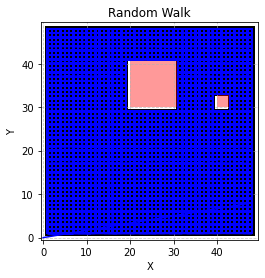

Number of times the walk goes around the hole: 8


In [162]:
# Create an instance of the Brownian class
brownian = Brownian(M=50)

# Generate a random walk with bias
#bias = {'up': 0.2, 'down': 0.3, 'right': 0.1, 'left': 0.4}
walk_x, walk_y = brownian.gen_random_walk(n_steps=100000, bias=None)

# Draw the map with the random walk
brownian.draw_plot(walk_x, walk_y)


hole_passes = brownian.count_hole_passes(walk_x, walk_y)
print("Number of times the walk goes around the hole:", hole_passes)
